In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

# Simulation

In [19]:
N = 1000
K = 10
mu = 2.5
Lambda = 1
theta = 0.2
X = np.ones(N)
X[:N//2] *= -5
X[N//2:] *= 5

X_T = np.zeros((1, N))
X_T[0] = X

T = 100
actions = []
Delta = np.zeros(6)
Delta[:2] = [mu, mu]
Delta[2:4] = [K*Lambda, K*Lambda]

data = np.zeros((0, 5))
lob = np.zeros((0, 20))

t = 0
a, b = N//2, N//2-1
while t<T:
    a, b = 0, N-1
    while b>0 and X[b]>=0: 
        b -=1
            
    while a<N-1 and X[a]<=0:
        a += 1
            
    a_price, b_price = int(X[a]), int(X[b])
    A = X[b+1: b+K+1]
    B = X[a-K: a]
    
    Delta[-1] = theta*np.sum(A)
    Delta[-2] = -theta*np.sum(B)
    rate = np.sum(Delta)
    delta = stats.expon(scale = 1/rate).rvs()
    i = np.random.choice(6,p = Delta/rate)
    
    if i == 0:
        X[a] -= 1
    elif i == 1:
        X[b] += 1
    elif i == 2:
        k = np.random.randint(1,K+1)
        X[a-k] -= 1
        if a-k > b:
            b = a-k 
    elif i == 3:
        k = np.random.randint(1,K+1)
        X[b+k] += 1
        if b+k < a:
            a = b+k 
    elif i == 4:
        k = np.random.choice(len(B),p=B/np.sum(B))
        X[a-K+k] += 1
    else:
        k = np.random.choice(len(A),p=A/np.sum(A))+1
        X[b+k] -= 1
        
    actions.append(i)
    t += delta
    X_T = np.concatenate([X_T, np.expand_dims(X,axis = 0)])
    temp = np.zeros((1,5))
    temp[0,:] = [t, b_price, a_price,(b_price+a_price)/2,a_price-b_price]
    data = np.concatenate([data, temp])
    temp_ = np.zeros((1, 20))
    temp_[0, :10] = X[b-9:b+1]
    temp_[0, 10:] = X[a:a+10]
    lob = np.concatenate([lob, temp_])
    #print(t)



# Sanity Check

In [20]:
header = ['ts', 'bid price', 'ask price', 'mid price', 'spread']

df = pd.DataFrame(data = data, columns = header)
mins = (df["ts"]//60).astype("int").astype("str").str.zfill(2)
secs = (df["ts"]%60*10**6).astype("int").astype("str").str.zfill(8)
dt = mins.str.cat(secs)
df["ts"] = pd.to_datetime(dt,format = "%M%S%f")

In [21]:
df.head()

,ts,bid price,ask price,mid price,spread
0,1900-01-01 00:00:00.002295,-5.0,5.0,0.0,10.0
1,1900-01-01 00:00:00.019505,-5.0,5.0,0.0,10.0
2,1900-01-01 00:00:00.025606,-5.0,5.0,0.0,10.0
3,1900-01-01 00:00:00.045860,-5.0,5.0,0.0,10.0
4,1900-01-01 00:00:00.055686,-5.0,5.0,0.0,10.0


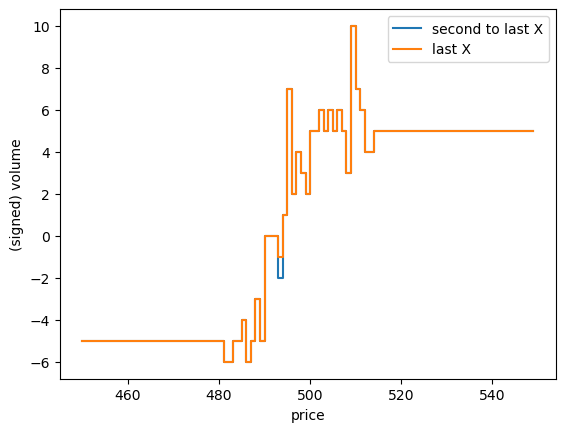

In [22]:
fig,ax = plt.subplots()
ax.step(range(450,550),X_T[-2,450:550])
ax.step(range(450,550),X_T[-1,450:550])
ax.legend(["second to last X", "last X"])
ax.set_xlabel("price")
ax.set_ylabel("(signed) volume")
plt.show()

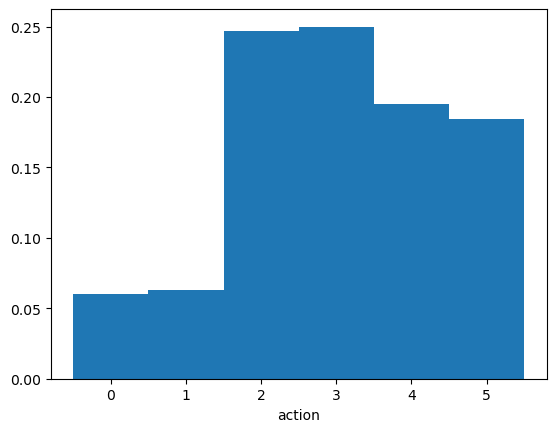

In [23]:
plt.hist(actions,bins = [-0.5+i for i in range(7)],density = True)
plt.xlabel('action')
plt.show()

# Plot the average shape of the simulated LOB. Compute an approximation of the value of the average shape away from the best bid and ask, using a queuing model. Are your simulations in agreement with the analytical result ?

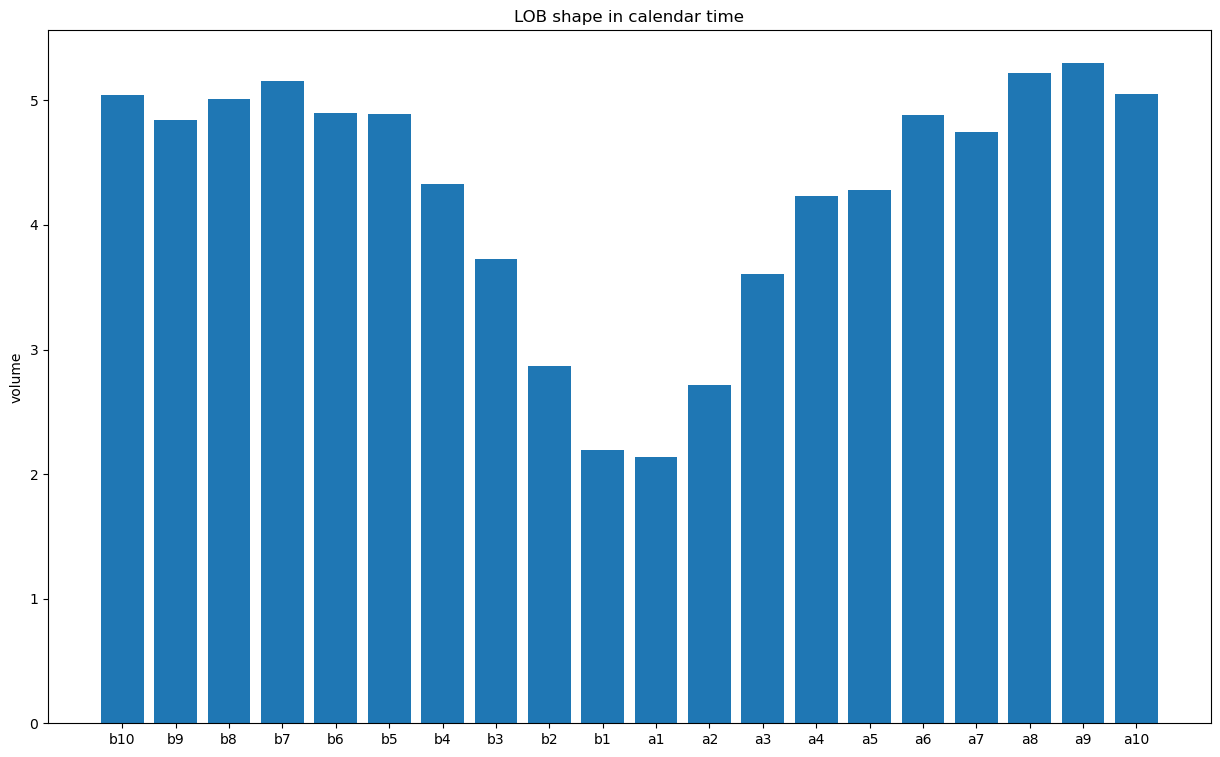

In [24]:
fig,ax = plt.subplots(figsize = (15,9))
ax.bar(range(20),np.abs(np.mean(lob,axis = 0)))
ax.set_xticks(range(20))
ax.set_xticklabels(["b"+str(10-i) for i in range(10)]+["a"+str(i+1) for i in range(10)])
ax.set_title("LOB shape in calendar time")
ax.set_ylabel("volume")
plt.show()

# Plot the spread distribution.


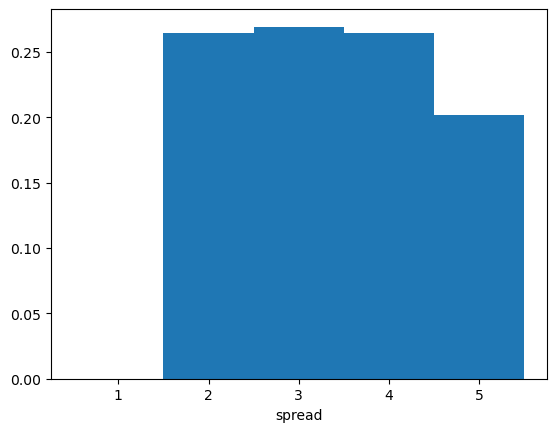

In [25]:
fig,ax = plt.subplots()
ax.hist(df["spread"],bins = [0.5+i for i in range(6)],density = True)
ax.set_xlabel("spread")
plt.show()

# Plot the mid-price variation at a large scale

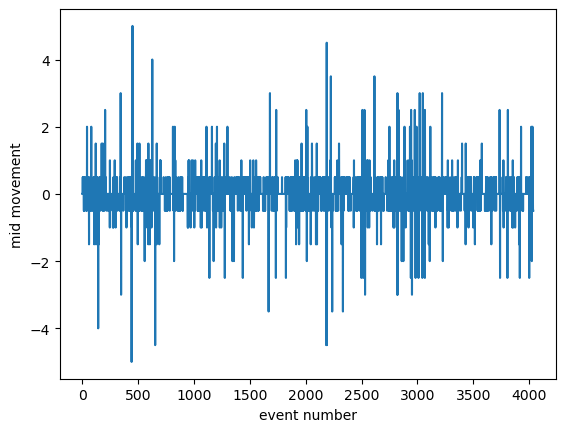

In [26]:
incs = df["mid price"].diff().dropna()
fig,ax = plt.subplots()
ax.plot(incs)
ax.set_xlabel("event number")
ax.set_ylabel("mid movement")
plt.show()

# Plot the distribution of mid-price increments for several sampling periods. Comment

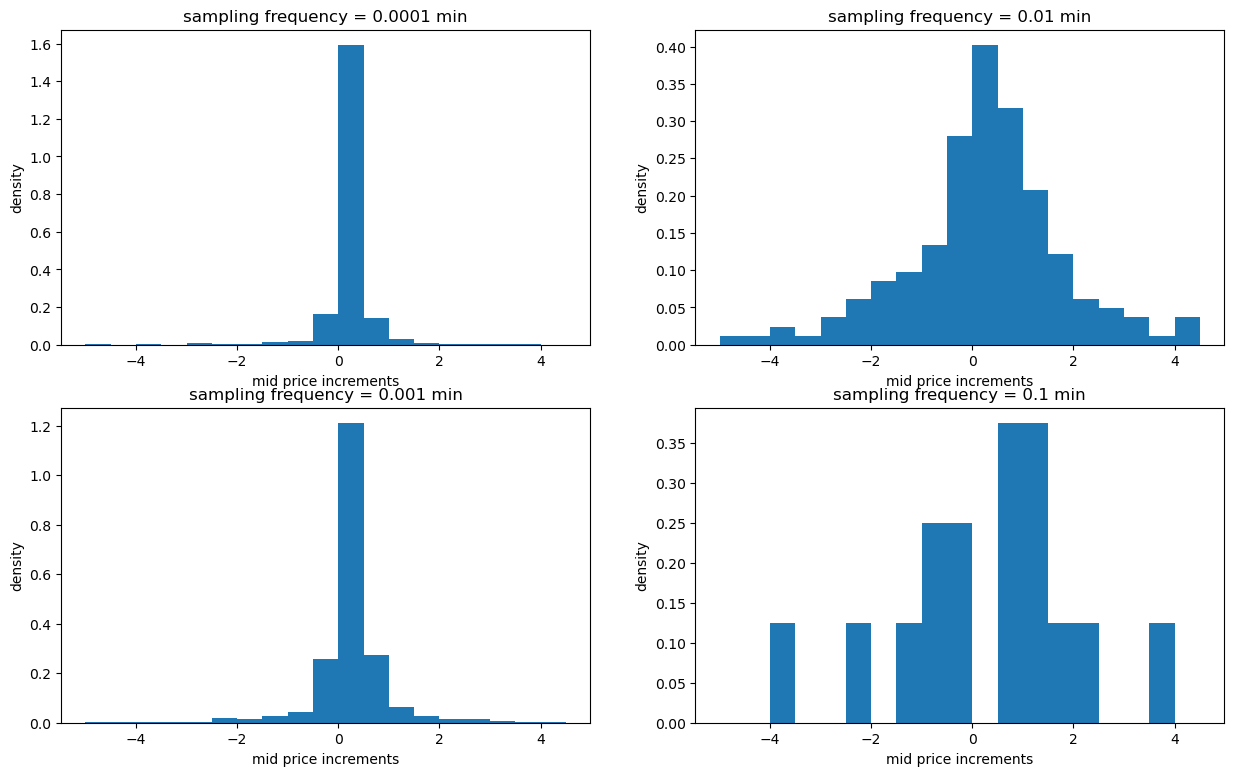

In [27]:
i = 0
j = 0
k = 0
fig,ax = plt.subplots(2,2, figsize = (15,9))
for t in ["0.0001","0.001","0.01","0.1"]:
    df_resampled = df.resample(t+"T",on = "ts").first()
    incs = df_resampled["mid price"].diff().dropna()
    ax[i,j].hist(incs,bins = [-5+i/2 for i in range(20)],density = True)
    ax[i,j].set_xlabel("mid price increments")
    ax[i,j].set_ylabel("density")
    ax[i,j].set_title("sampling frequency = {} min".format(t)) 
    k += 1
    j = k//2
    i = k%2
plt.show()

When the sampling frequency is low, the mass of the distribution of the mid price variation is concentrated around 0.

# Plot the autocorrelation function of the mid-price increments. Comment.


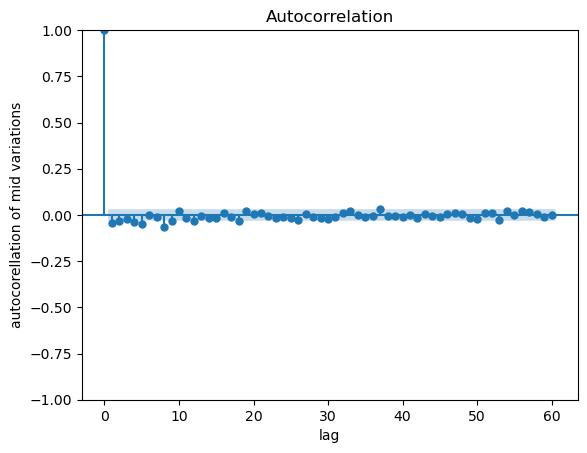

In [28]:
fig,ax = plt.subplots()
incs = df["mid price"].diff().dropna()
plot_acf(incs, lags=60, ax = ax)
ax.set_xlabel("lag")
ax.set_ylabel("autocorellation of mid variations")
plt.show()

# Plot the variance of mid-price increments as a function of the sampling period. Comment.

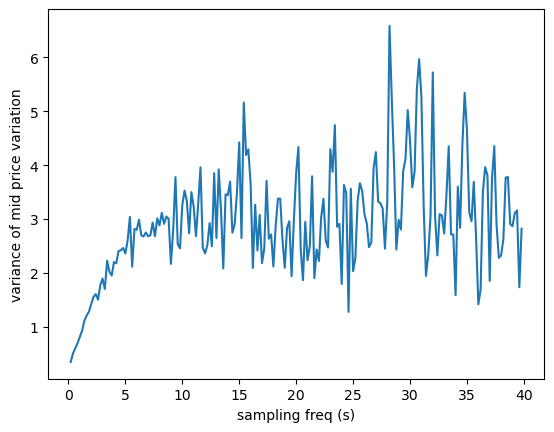

In [29]:
var= []
for t in [str(i/100) for i in range(2,400,2)]:
    df_resampled = df.resample(t+"S",on = "ts").first()
    incs = df_resampled["mid price"].diff().dropna()
    var += [np.var(incs)]
fig,ax = plt.subplots()
ax.plot([i/10 for i in range(2,400,2)], var)
ax.set_xlabel("sampling freq (s)")
ax.set_ylabel("variance of mid price variation")
plt.show()